In [1]:
#LIBRERIAS
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras import layers, models, regularizers
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
import seaborn as sns
import collections

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#retina_df = pd.read_csv("../Datos/Retina_DF_BAL.csv")
retina_df = pd.read_csv("../content/drive/MyDrive/Img_Preprocessing_v4/Retina_DF_BAL.csv")

retina_df.head(6)

,image,level,id_Paciente,path,existe,tipo,eye
0,19521_left,2,19521,..\Datos\Train\19521_left.jpeg,True,MODERADA,0
1,19522_right,3,19522,..\Datos\Train\19522_right.jpeg,True,SEVERA,1
2,14482_left,3,14482,..\Datos\Train\14482_left.jpeg,True,SEVERA,0
3,13267_right,2,13267,..\Datos\Train\13267_right.jpeg,True,MODERADA,1
4,34879_left,0,34879,..\Datos\Train\34879_left.jpeg,True,NO RD,0
5,27922_left,3,27922,..\Datos\Train\27922_left.jpeg,True,SEVERA,0


In [4]:
retina_df.shape

(3500, 7)

In [5]:
direccion = "../content/drive/MyDrive/Img_Preprocessing_v4/"
lear_rate = 0.0005
batch_tam = 32
dimensiones = 224
num_clases = 5

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    direccion,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(dimensiones, dimensiones),
    batch_size=batch_tam)

val_ds = tf.keras.utils.image_dataset_from_directory(
    direccion,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(dimensiones, dimensiones),
    batch_size=batch_tam)

Found 3500 files belonging to 5 classes.
Using 2800 files for training.
Found 3500 files belonging to 5 classes.
Using 700 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['LEVE', 'MODERADA', 'NO RD', 'RD PROLIFERA', 'SEVERA']


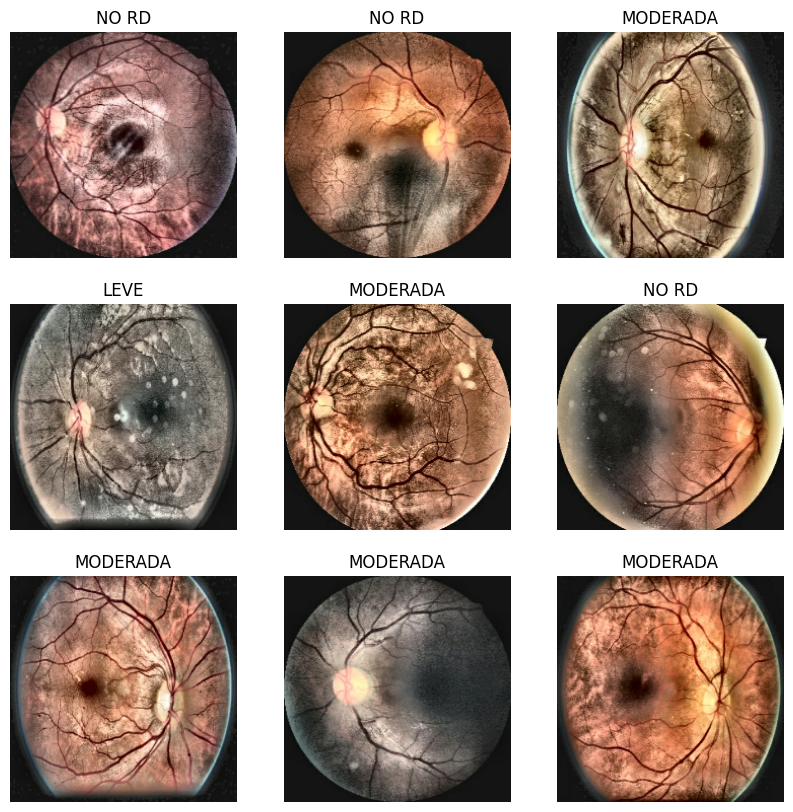

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
from tensorflow import keras

In [10]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
])

normalization_layer = layers.Rescaling(1./255)

In [11]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
#train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

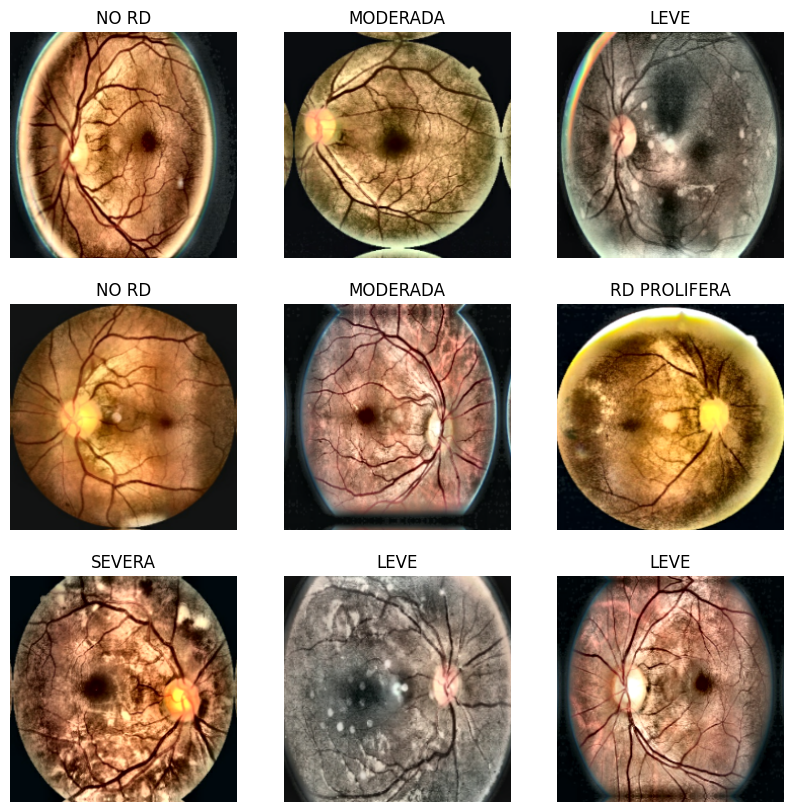

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i].numpy()).astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
num_classes = 5

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# model.compile(
#   optimizer='adam',
#   loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
#   metrics=['accuracy'])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [16]:
history = model.fit(train_ds,
                    epochs=100,
                    callbacks=[early_stopping],
                    steps_per_epoch=len(train_ds),
                    validation_data=val_ds,
                    validation_steps=len(val_ds))

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 476s 5s/step - accuracy: 0.2012 - loss: 1.7768 - val_accuracy: 0.2543 - val_loss: 1.7171
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 407s 4s/step - accuracy: 0.2432 - loss: 1.7072 - val_accuracy: 0.2571 - val_loss: 1.6904
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 378s 4s/step - accuracy: 0.2702 - loss: 1.6721 - val_accuracy: 0.3029 - val_loss: 1.6593
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 384s 4s/step - accuracy: 0.3109 - loss: 1.6299 - val_accuracy: 0.3029 - val_loss: 1.6368
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 401s 5s/step - accuracy: 0.3269 - loss: 1.5893 - val_accuracy: 0.3114 - val_loss: 1.6200
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 423s 4s/step - accuracy: 0.3671 - loss: 1.5469 - val_accuracy: 0.3114 - val_loss: 1.6023
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 395s 4s/step - accuracy: 0.3978 - loss: 1.5063 - val_accuracy: 0.3229 - val_loss: 1.5879
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 447s 5s/step - accuracy: 0.4262 - loss: 1.4520 - val_accuracy: 0.

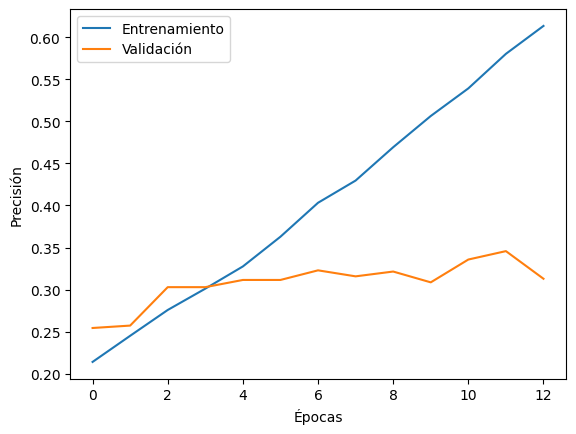

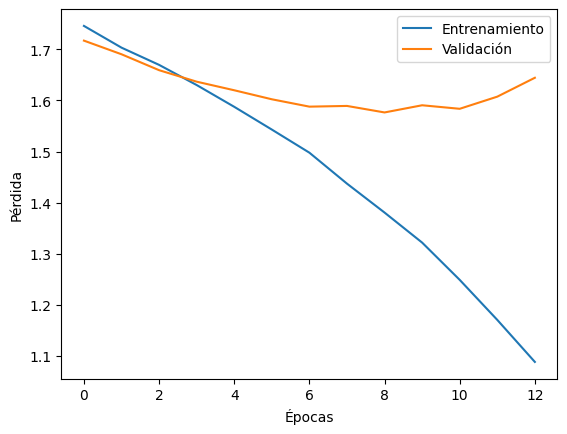

In [17]:
# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [32]:
y_pred = model.predict(val_ds)
y_ref = np.argmax(y_pred, axis=1)

22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step


In [33]:
y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())

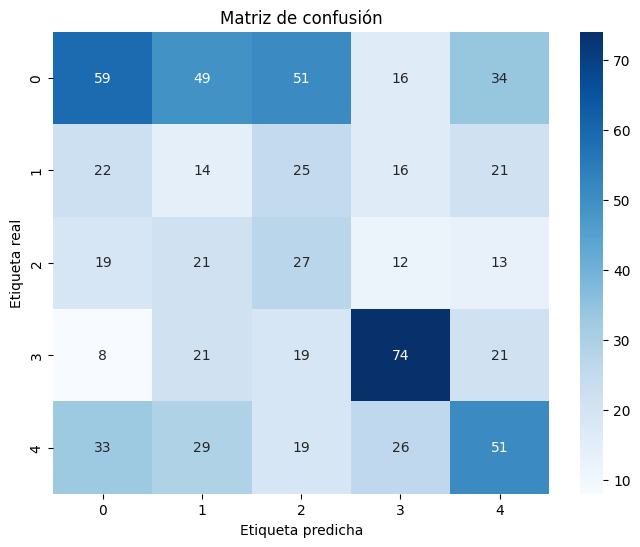

In [34]:
matriz_conf = confusion_matrix(y_ref,y_true)
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_conf, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de confusión")
plt.xlabel("Etiqueta predicha")
plt.ylabel("Etiqueta real")
plt.show()